# Decentralized Federated Learning Simulation

**Implementation of decentralized FL without parameter server**
- Network topologies: Ring, Star, Small World
- MNIST dataset with IID distribution  
- Parameter aggregation: `(1-ρ) × old + ρ × neighbor_avg`

In [73]:
# Import necessary libraries for decentralized federated learning simulation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from collections import Counter, defaultdict

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import random
import copy
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Libraries imported")

Libraries imported


In [63]:
# Network Topology Creation for Decentralized Federated Learning

class NetworkTopology:
    """Class to create and manage different network topologies for decentralized FL
        Ring - Sequential neighbor connections
        Fully Connected - All clients connected to all others
        Star - One central client connected to all others
        Random - Probabilistic connections with guaranteed connectivity
        Small World - Watts-Strogatz model with good clustering and short paths
        Grid - 2D lattice structure for geographic scenarios
    """
    
    def __init__(self, num_clients: int = 5):
        self.num_clients = min(num_clients, 10)  # Limit to 10 clients
        self.clients = list(range(self.num_clients))
    
    def _relabel_nodes(self, G: nx.Graph) -> nx.Graph:
        """Relabel nodes to be sequential integers"""
        mapping = {node: i for i, node in enumerate(G.nodes())}
        G = nx.relabel_nodes(G, mapping)
        return G
    
    def create_ring_topology(self) -> nx.Graph:
        """Create a ring topology where each client connects to its neighbors"""
        G = nx.cycle_graph(self.num_clients)
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(self.num_clients)}, 'name')
        return G
    
    def create_fully_connected_topology(self) -> nx.Graph:
        """Create a fully connected topology where every client connects to every other"""
        G = nx.complete_graph(self.num_clients)
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(self.num_clients)}, 'name')
        return G
    
    def create_star_topology(self) -> nx.Graph:
        """Create a star topology with one central client connected to all others"""
        G = nx.star_graph(self.num_clients - 1)
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(self.num_clients)}, 'name')
        return G
    
    def create_random_topology(self, edge_probability: float = 0.3) -> nx.Graph:
        """Create a random topology with given edge probability"""
        G = nx.erdos_renyi_graph(self.num_clients, edge_probability)
        # Ensure connectivity
        if not nx.is_connected(G):
            # Add edges to make it connected
            components = list(nx.connected_components(G))
            for i in range(len(components) - 1):
                node1 = list(components[i])[0]
                node2 = list(components[i + 1])[0]
                G.add_edge(node1, node2)
        
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(self.num_clients)}, 'name')
        return G
    
    def create_small_world_topology(self, k: int = 4, p: float = 0.3) -> nx.Graph:
        """
        Create a small-world topology using the Watts-Strogatz model.

        Parameters:
            k (int): Each node is connected to k nearest neighbors in the ring topology.
            p (float): Probability of rewiring each edge.

        Returns:
            nx.Graph: A small-world network graph.
        """
        # Ensure k is even and less than num_clients
        k = min(k, self.num_clients - 1)
        if k % 2 == 1:
            k -= 1
        if k < 2:
            k = 2
            
        G = nx.watts_strogatz_graph(self.num_clients, k, p)
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(self.num_clients)}, 'name')
        return G
    
    def create_grid_topology(self) -> nx.Graph:
        """Create a 2D grid topology (works best with square numbers of clients)"""
        # Find closest square grid
        grid_size = int(np.sqrt(self.num_clients))
        if grid_size * grid_size < self.num_clients:
            grid_size += 1
        
        G = nx.grid_2d_graph(grid_size, grid_size)
        
        # Remove extra nodes if needed
        nodes_to_remove = []
        for i, node in enumerate(G.nodes()):
            if i >= self.num_clients:
                nodes_to_remove.append(node)
        G.remove_nodes_from(nodes_to_remove)
        
        G = self._relabel_nodes(G)
        
        nx.set_node_attributes(G, {i: f"Client_{i}" for i in range(G.number_of_nodes())}, 'name')
        return G
    
    def women_social_network(self) -> nx.Graph:
        """Davis Southern women social network"""
        G = nx.davis_southern_women_graph()
        G = self._relabel_nodes(G)
        return G
    
    def karate_graph(self) -> nx.Graph:
        """Zachary’s Karate Club graph"""
        G = nx.karate_club_graph()
        G = self._relabel_nodes(G)
        return G
    
    def florentine_families(self) -> nx.Graph:
        """Florentine families marriage network"""
        G = nx.florentine_families_graph()
        G = self._relabel_nodes(G)
        return G
    
    def get_topology_info(self, G: nx.Graph) -> Dict:
        """Get information about the topology"""
        return {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'average_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
            'min_degree': min(dict(G.degree()).values()),
            'max_degree': max(dict(G.degree()).values()),
            'most_frequent_degree': max(set(dict(G.degree()).values()), key=list(dict(G.degree()).values()).count),
            'diameter': nx.diameter(G) if nx.is_connected(G) else 'Not connected',
            'clustering_coefficient': nx.average_clustering(G),
            'is_connected': nx.is_connected(G)
        }



In [35]:
# Visualization Functions for Network Topologies

def plot_topology(G: nx.Graph, title: str, layout_type: str = 'spring') -> None:
    """Plot a network topology using matplotlib"""
    plt.figure(figsize=(10, 8))
    
    # Choose layout
    if layout_type == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout_type == 'circular':
        pos = nx.circular_layout(G)
    elif layout_type == 'shell':
        pos = nx.shell_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)
    
    # Draw the network
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=1000,
            font_size=10,
            font_weight='bold',
            edge_color='gray',
            width=2,
            alpha=0.7)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_interactive_topology(G: nx.Graph, title: str) -> None:
    """Create an interactive plot using Plotly"""
    # Get layout positions
    pos = nx.spring_layout(G, seed=42)
    
    # Extract edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    # Create edge trace
    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                           line=dict(width=2, color='#888'),
                           hoverinfo='none',
                           mode='lines')
    
    # Extract nodes
    node_x = []
    node_y = []
    node_text = []
    node_info = []
    
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f'Client {node}')
        
        # Node info for hover
        adjacencies = list(G.neighbors(node))
        node_info.append(f'Client {node}<br>Connections: {len(adjacencies)}<br>Neighbors: {adjacencies}')
    
    # Create node trace
    node_trace = go.Scatter(x=node_x, y=node_y,
                           mode='markers+text',
                           hoverinfo='text',
                           text=node_text,
                           textposition="middle center",
                           hovertext=node_info,
                           marker=dict(showscale=True,
                                     colorscale='Blues',
                                     reversescale=True,
                                     color=[],
                                     size=30,
                                     colorbar=dict(
                                         thickness=15,
                                         len=0.5,
                                         x=1.02,
                                         xanchor="left",
                                         title="Node Connections"
                                     ),
                                     line=dict(width=2)))
    
    # Color nodes by number of connections
    node_adjacencies = []
    for node in G.nodes():
        node_adjacencies.append(len(list(G.neighbors(node))))
    
    node_trace.marker.color = node_adjacencies
    
    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(
                        title=dict(text=title, font=dict(size=16)),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    
    fig.show()

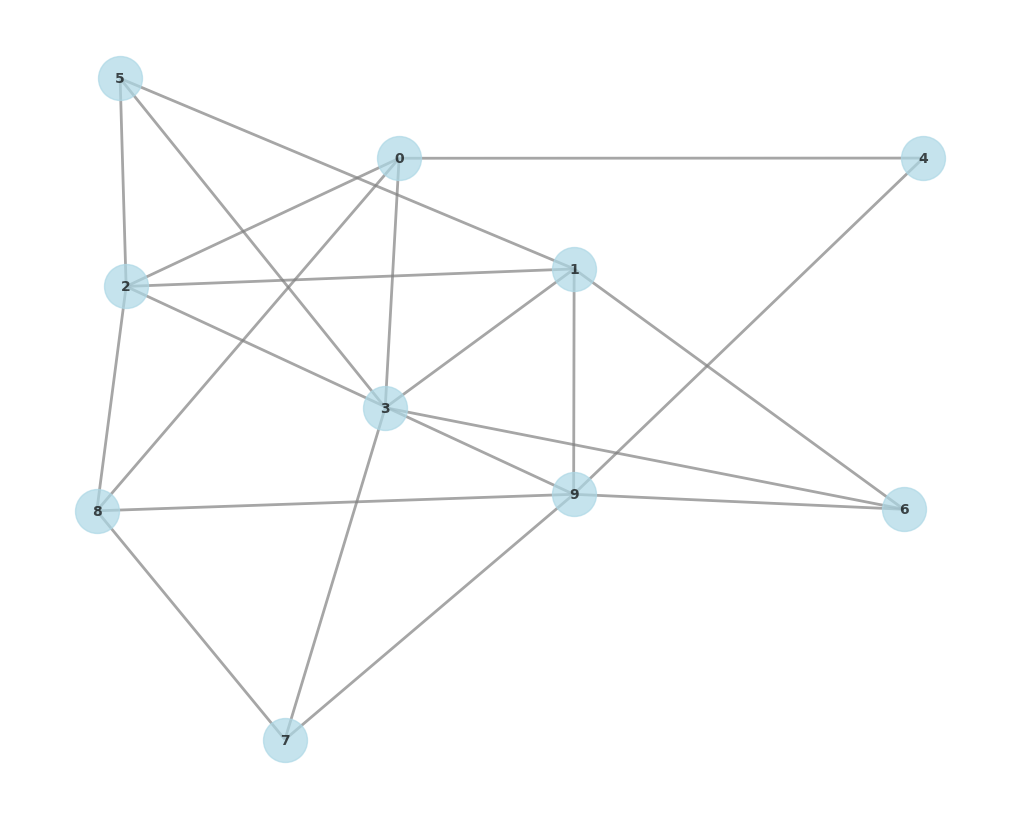

{'num_nodes': 10,
 'num_edges': 20,
 'density': 0.4444444444444444,
 'average_degree': 4.0,
 'min_degree': 2,
 'max_degree': 6,
 'most_frequent_degree': 3,
 'diameter': 3,
 'clustering_coefficient': 0.37,
 'is_connected': True}

In [68]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Generate a topology
network = NetworkTopology(num_clients=10)
G = network.create_random_topology(edge_probability=0.4)#(k=4, p=0.1)


# Plot ropology
plot_topology(G, title="")
network.get_topology_info(G)

In [ ]:
# Data Distribution for Decentralized Federated Learning

class DataDistributor:
    """Class to handle data distribution among federated learning clients"""
    
    def __init__(self, num_clients: int, dataset_name: str = 'mnist'):
        self.num_clients = num_clients
        self.dataset_name = dataset_name.lower()
        self.client_data = {}
        self.client_loaders = {}
        
    def load_mnist_data(self, data_dir: str = './data') -> Tuple[Dataset, Dataset]:
        """Load MNIST dataset"""
        # Data preprocessing
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
        ])
        
        # Download and load MNIST
        train_dataset = datasets.MNIST(
            root=data_dir,
            train=True,
            download=True,
            transform=transform
        )
        
        test_dataset = datasets.MNIST(
            root=data_dir,
            train=False,
            download=True,
            transform=transform
        )
        
        return train_dataset, test_dataset


    def distribute_iid_data(self, batch_size: int = 32, data_dir: str = './data', verbose=False) -> Dict[int, Dict]:
        """Distribute MNIST data in IID manner among clients"""
        # Load MNIST dataset
        train_dataset, test_dataset = self.load_mnist_data(data_dir)
        
        # Calculate samples per client
        train_samples_per_client = len(train_dataset) // self.num_clients
        test_samples_per_client = len(test_dataset) // self.num_clients
        
        # Randomly shuffle indices
        train_indices = torch.randperm(len(train_dataset)).tolist()
        test_indices = torch.randperm(len(test_dataset)).tolist()
        
        # Distribute data to clients
        for client_id in range(self.num_clients):
            # Calculate start and end indices for this client
            train_start = client_id * train_samples_per_client
            train_end = (client_id + 1) * train_samples_per_client
            
            test_start = client_id * test_samples_per_client
            test_end = (client_id + 1) * test_samples_per_client
            
            # Handle remainder for last client
            if client_id == self.num_clients - 1:
                train_end = len(train_dataset)
                test_end = len(test_dataset)
            
            # Get client's data indices
            client_train_indices = train_indices[train_start:train_end]
            client_test_indices = test_indices[test_start:test_end]
            
            # Create subset datasets for this client
            client_train_dataset = torch.utils.data.Subset(train_dataset, client_train_indices)
            client_test_dataset = torch.utils.data.Subset(test_dataset, client_test_indices)

            # Print the label distribution for this client
            train_labels = [train_dataset.targets[i] for i in client_train_indices]
            test_labels = [test_dataset.targets[i] for i in client_test_indices]
            
            # Labels to int
            train_labels = [int(label) for label in train_labels]
            test_labels = [int(label) for label in test_labels]
            
            if verbose:
                print(f"Client {client_id} - Train labels: {Counter(train_labels)}")
                print(f"Client {client_id} - Test labels: {Counter(test_labels)}")
                # Total samples
                print(f"Client {client_id} - Total train samples: {len(client_train_dataset)}")
                print(f"Client {client_id} - Total test samples: {len(client_test_dataset)}")
                print()

            # Create data loaders
            train_loader = DataLoader(
                client_train_dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False
            )
            
            test_loader = DataLoader(
                client_test_dataset,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False
            )
            
            # Store client data information
            self.client_data[client_id] = {
                'train_dataset': client_train_dataset,
                'test_dataset': client_test_dataset,
                'train_samples': len(client_train_dataset),
                'test_samples': len(client_test_dataset),
                'train_indices': client_train_indices,
                'test_indices': client_test_indices
            }
            
            self.client_loaders[client_id] = {
                'train_loader': train_loader,
                'test_loader': test_loader
            }
        
        return self.client_data
    
    


    def distribute_dirichlet_data(self, alpha: float = 0.5, batch_size: int = 32, data_dir: str = './data', verbose=False) -> Dict[int, Dict]:
        """
        Distribute MNIST data in a Non-IID manner using Dirichlet distribution for training,
        and uniformly (IID) for test set.
        
        Args:
            alpha: Dirichlet concentration parameter. 
                Smaller alpha -> more skewed distributions across clients.
            batch_size: Batch size for DataLoader.
            data_dir: Directory to load MNIST data.
        """
        # Load MNIST dataset
        train_dataset, test_dataset = self.load_mnist_data(data_dir)

        # Train labels
        train_labels = np.array(train_dataset.targets)

        # Group train indices by class
        train_indices_by_class = {i: np.where(train_labels == i)[0] for i in range(10)}

        # Init client storage
        for client_id in range(self.num_clients):
            self.client_data[client_id] = {
                'train_indices': [],
                'test_indices': []
            }

        # --- Dirichlet partition for training set ---
        for c in range(10):  # for each class
            idxs = train_indices_by_class[c]
            np.random.shuffle(idxs)

            # Dirichlet proportions
            proportions = np.random.dirichlet(alpha=np.repeat(alpha, self.num_clients))

            # Split according to proportions
            split_points = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
            split_indices = np.split(idxs, split_points)

            for client_id, client_split in enumerate(split_indices):
                self.client_data[client_id]['train_indices'].extend(client_split.tolist())

        # --- Uniform partition for test set ---
        test_indices = torch.randperm(len(test_dataset)).tolist()
        test_samples_per_client = len(test_dataset) // self.num_clients

        for client_id in range(self.num_clients):
            start = client_id * test_samples_per_client
            end = (client_id + 1) * test_samples_per_client if client_id != self.num_clients - 1 else len(test_dataset)

            self.client_data[client_id]['test_indices'] = test_indices[start:end]

        # --- Build loaders and datasets ---
        test_labels = np.array(test_dataset.targets)
        for client_id in range(self.num_clients):
            client_train_dataset = torch.utils.data.Subset(train_dataset, self.client_data[client_id]['train_indices'])
            client_test_dataset = torch.utils.data.Subset(test_dataset, self.client_data[client_id]['test_indices'])

            # Print label distribution
            train_lbls = [int(train_labels[i]) for i in self.client_data[client_id]['train_indices']]
            test_lbls = [int(test_labels[i]) for i in self.client_data[client_id]['test_indices']]
            
            if verbose:
                print(f"Client {client_id} - Train labels: {Counter(train_lbls)}")
                print(f"Client {client_id} - Test labels: {Counter(test_lbls)}")
                # Total samples
                print(f"Client {client_id} - Total train samples: {len(client_train_dataset)}")
                print(f"Client {client_id} - Total test samples: {len(client_test_dataset)}")
                print()

            # Create data loaders
            train_loader = DataLoader(client_train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
            test_loader = DataLoader(client_test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

            # Store info
            self.client_data[client_id].update({
                'train_dataset': client_train_dataset,
                'test_dataset': client_test_dataset,
                'train_samples': len(client_train_dataset),
                'test_samples': len(client_test_dataset)
            })
            self.client_loaders[client_id] = {
                'train_loader': train_loader,
                'test_loader': test_loader
            }

        return self.client_data

    def get_data_summary(self) -> Dict:
        """Get summary of data distribution"""
        if not self.client_data:
            return {}
        
        total_train = sum(client['train_samples'] for client in self.client_data.values())
        total_test = sum(client['test_samples'] for client in self.client_data.values())
        
        return {
            'total_clients': self.num_clients,
            'total_train_samples': total_train,
            'total_test_samples': total_test,
            'avg_train_per_client': total_train // self.num_clients,
            'avg_test_per_client': total_test // self.num_clients
        }
    
    def get_client_loader(self, client_id: int, loader_type: str = 'train') -> DataLoader:
        """Get data loader for a specific client"""
        if client_id not in self.client_loaders:
            raise ValueError(f"Client {client_id} not found. Available clients: {list(self.client_loaders.keys())}")
        
        if loader_type not in ['train', 'test']:
            raise ValueError("loader_type must be 'train' or 'test'")
        
        return self.client_loaders[client_id][f'{loader_type}_loader']

    def plot_heatmap(self) -> None:
        """Plot heatmap of label distribution across clients"""
        if not self.client_data:
            print("No client data available to plot.")
            return
        
        # Prepare data
        label_counts = np.zeros((self.num_clients, 10), dtype=int)
        
        for client_id in range(self.num_clients):
            train_labels = [int(label) for label in self.client_data[client_id]['train_dataset'].dataset.targets[self.client_data[client_id]['train_indices']]]
            counts = Counter(train_labels)
            for label, count in counts.items():
                label_counts[client_id, label] = count
        
        # Create DataFrame for seaborn
        df = pd.DataFrame(label_counts, columns=[f'Label_{i}' for i in range(10)], index=[f'Client_{i}' for i in range(self.num_clients)])
        
        plt.figure(figsize=(10, 6))
        #sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
        # Fix heatmap to be from 0 to total_labels/num_clients
        sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu', vmin=0, vmax=np.max(label_counts))
        plt.title('Label Distribution Across Clients', fontsize=16)
        plt.xlabel('Labels', fontsize=14)
        plt.ylabel('Clients', fontsize=14)
        plt.tight_layout()
        plt.show()

Client 0 - Train labels: Counter({8: 1177, 9: 306, 4: 22, 2: 2, 3: 1})
Client 0 - Test labels: Counter({1: 124, 3: 117, 9: 116, 8: 102, 2: 100, 4: 98, 5: 91, 0: 85, 7: 85, 6: 82})
Client 0 - Total train samples: 1508
Client 0 - Total test samples: 1000

Client 1 - Train labels: Counter({0: 1506, 1: 1312, 7: 373, 3: 140, 9: 9, 2: 8, 6: 4, 4: 1})
Client 1 - Test labels: Counter({0: 116, 7: 110, 1: 103, 9: 102, 2: 101, 8: 99, 4: 99, 6: 94, 5: 88, 3: 88})
Client 1 - Total train samples: 3353
Client 1 - Total test samples: 1000

Client 2 - Train labels: Counter({8: 4182, 6: 47, 2: 21})
Client 2 - Test labels: Counter({1: 128, 4: 116, 2: 102, 7: 100, 8: 99, 3: 98, 5: 95, 9: 93, 6: 93, 0: 76})
Client 2 - Total train samples: 4250
Client 2 - Total test samples: 1000

Client 3 - Train labels: Counter({3: 5947, 1: 1891, 4: 395, 7: 98, 6: 11, 9: 11, 5: 4})
Client 3 - Test labels: Counter({9: 116, 1: 115, 5: 105, 0: 105, 2: 104, 8: 93, 4: 91, 7: 91, 6: 90, 3: 90})
Client 3 - Total train samples: 8

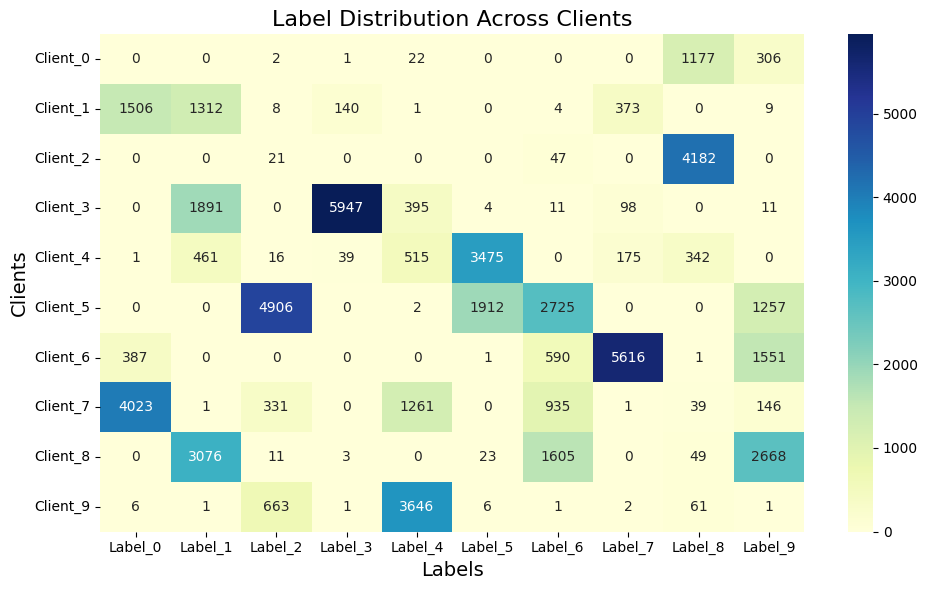

In [ ]:
# Setup data distribution
num_clients = 10
data_distributor = DataDistributor(num_clients=num_clients, dataset_name='mnist')
client_data_info = data_distributor.distribute_dirichlet_data(batch_size=64, alpha=0.1, data_dir='./data')

print(f"Data ready: {num_clients} clients, {data_distributor.get_data_summary()['avg_train_per_client']} samples each")
# Visualize label distribution
data_distributor.plot_heatmap()

In [13]:
# Clean Decentralized Federated Learning Simulation

class SimpleMNISTModel(nn.Module):
    """Lightweight CNN for MNIST"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class DecentralizedClient:
    """Minimal FL client for decentralized learning"""
    def __init__(self, client_id, train_loader, test_loader, neighbors):
        self.client_id = client_id
        self.neighbors = neighbors
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = SimpleMNISTModel()
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.CrossEntropyLoss()
    
    def train_local(self, epochs=1):
        """Train locally on client data"""
        self.model.train()
        total_loss = 0
        for _ in range(epochs):
            for data, target in self.train_loader:
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
        return total_loss / len(self.train_loader)
    
    def evaluate(self):
        """Evaluate on test data"""
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                output = self.model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        return 100. * correct / total
    
    def get_parameters(self):
        """Get model parameters"""
        return {name: param.clone().detach() for name, param in self.model.named_parameters()}
    
    def set_parameters(self, params):
        """Set model parameters"""
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in params:
                    param.copy_(params[name])
    
    def select_neighbors(self, selection_strategy='random', selection_ratio=0.5):
        """Select subset of neighbors for communication"""
        if not self.neighbors:
            return []
        
        if selection_strategy == 'random':
            num_selected = max(1, int(len(self.neighbors) * selection_ratio))
            return random.sample(self.neighbors, num_selected)
        elif selection_strategy == 'all':
            return self.neighbors.copy()
        else:
            return []
    
    def transmit_to_selected(self, selected_neighbors, all_clients):
        """Transmit model parameters to selected neighbors"""
        my_params = self.get_parameters()
        transmitted_to = []
        
        for neighbor_id in selected_neighbors:
            if neighbor_id in all_clients:
                # Store received model in neighbor's received_models
                all_clients[neighbor_id].receive_model(self.client_id, my_params)
                transmitted_to.append(neighbor_id)
        
        return transmitted_to
    
    def receive_model(self, sender_id, model_params):
        """Receive and store model parameters from another client"""
        if not hasattr(self, 'received_models'):
            self.received_models = {}
        self.received_models[sender_id] = model_params
    
    def aggregate_received_models(self, rho=0.1):
        """Aggregate own model with received models from other clients"""
        current_params = self.get_parameters()
        
        if not hasattr(self, 'received_models') or not self.received_models:
            return  # No models received, keep current model
        
        # Get all received model parameters
        received_params_list = list(self.received_models.values())
        
        # Average all received parameters
        avg_received_params = {}
        for name in current_params.keys():
            received_tensors = [rp[name] for rp in received_params_list if name in rp]
            if received_tensors:
                avg_received_params[name] = torch.stack(received_tensors).mean(dim=0)
            else:
                avg_received_params[name] = current_params[name]
        
        # Apply aggregation: (1-rho)*own + rho*received_avg
        aggregated_params = {}
        for name in current_params.keys():
            aggregated_params[name] = (1 - rho) * current_params[name] + rho * avg_received_params[name]
        
        self.set_parameters(aggregated_params)
        
        # Clear received models for next round
        self.received_models = {}

def run_decentralized_fl(topology_type='ring', num_clients=6, num_rounds=5, local_epochs=2, rho=0.2, selection_strategy='random', selection_ratio=0.5):
    """Main decentralized FL simulation with 3-phase communication"""
    print(f"Running {topology_type} topology: {num_clients} clients, {num_rounds} rounds")
    print(f"Selection: {selection_strategy} ({selection_ratio*100:.0f}% of neighbors)")
    
    # Create topology and get neighbors
    topo = NetworkTopology(num_clients)
    if topology_type == 'ring':
        graph = topo.create_ring_topology()
    elif topology_type == 'star':
        graph = topo.create_star_topology()
    elif topology_type == 'small_world':
        graph = topo.create_small_world_topology()
    else:
        graph = topo.create_ring_topology()
    
    # Get neighbor information for each client
    neighbor_info = {i: list(graph.neighbors(i)) for i in range(num_clients)}
    
    # Create data distribution and clients
    data_dist = DataDistributor(num_clients)
    data_dist.distribute_iid_data(batch_size=32)
    
    clients = {}
    for i in range(num_clients):
        train_loader = data_dist.get_client_loader(i, 'train')
        test_loader = data_dist.get_client_loader(i, 'test')
        clients[i] = DecentralizedClient(i, train_loader, test_loader, neighbor_info[i])
    
    # Training rounds
    results = []
    
    for round_num in range(num_rounds):
        # Phase 1: Each client trains locally
        train_losses = []
        for client_id, client in clients.items():
            loss = client.train_local(epochs=local_epochs)
            train_losses.append(loss)
        
        # Phase 2: Client selection and model transmission
        transmission_log = {}
        for client_id, client in clients.items():
            # Each client selects neighbors to request models from
            selected_neighbors = client.select_neighbors(selection_strategy, selection_ratio)
            transmission_log[client_id] = selected_neighbors
            
            # Request models from selected neighbors (they transmit to this client)
            for neighbor_id in selected_neighbors:
                if neighbor_id in clients:
                    clients[neighbor_id].transmit_to_selected([client_id], clients)
        
        # Phase 3: Model aggregation
        for client_id, client in clients.items():
            client.aggregate_received_models(rho=rho)
        
        # Evaluate all clients
        test_accuracies = []
        for client_id, client in clients.items():
            acc = client.evaluate()
            test_accuracies.append(acc)
        
        # Store round results
        avg_loss = np.mean(train_losses)
        avg_acc = np.mean(test_accuracies)
        results.append({'round': round_num + 1, 'loss': avg_loss, 'accuracy': avg_acc})
        
        print(f"Round {round_num + 1}: Loss={avg_loss:.3f}, Accuracy={avg_acc:.1f}%")
    
    return results

print("Decentralized FL ready!")

Decentralized FL ready!


In [14]:
# Run Decentralized FL Simulation with 3-Phase Communication

print("Testing Ring Topology (50% neighbor selection):")
results_ring = run_decentralized_fl('ring', num_clients=6, num_rounds=3, local_epochs=1, rho=0.2, 
                                  selection_strategy='random', selection_ratio=0.5)

print("\nTesting Small World Topology (50% neighbor selection):")
results_sw = run_decentralized_fl('small_world', num_clients=6, num_rounds=3, local_epochs=1, rho=0.2,
                                selection_strategy='random', selection_ratio=0.5)

print(f"\nFinal Results:")
print(f"Ring: {results_ring[-1]['accuracy']:.1f}%")
print(f"Small World: {results_sw[-1]['accuracy']:.1f}%")

Testing Ring Topology (50% neighbor selection):
Running ring topology: 6 clients, 3 rounds
Selection: random (50% of neighbors)
Round 1: Loss=1.448, Accuracy=79.5%
Round 1: Loss=1.448, Accuracy=79.5%
Round 2: Loss=0.486, Accuracy=81.8%
Round 2: Loss=0.486, Accuracy=81.8%
Round 3: Loss=0.372, Accuracy=87.3%

Testing Small World Topology (50% neighbor selection):
Running small_world topology: 6 clients, 3 rounds
Selection: random (50% of neighbors)
Round 3: Loss=0.372, Accuracy=87.3%

Testing Small World Topology (50% neighbor selection):
Running small_world topology: 6 clients, 3 rounds
Selection: random (50% of neighbors)
Round 1: Loss=1.378, Accuracy=75.9%
Round 1: Loss=1.378, Accuracy=75.9%
Round 2: Loss=0.473, Accuracy=84.0%
Round 2: Loss=0.473, Accuracy=84.0%
Round 3: Loss=0.378, Accuracy=86.5%

Final Results:
Ring: 87.3%
Small World: 86.5%
Round 3: Loss=0.378, Accuracy=86.5%

Final Results:
Ring: 87.3%
Small World: 86.5%


In [15]:
# Test Different Selection Strategies

print("Comparing Selection Strategies on Ring Topology:")

print("\n1. All neighbors (100%):")
results_all = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                 selection_strategy='all', selection_ratio=1.0)

print("\n2. Random 50% neighbors:")  
results_50 = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                selection_strategy='random', selection_ratio=0.5)

print("\n3. Random 25% neighbors:")
results_25 = run_decentralized_fl('ring', num_clients=6, num_rounds=2, local_epochs=1, rho=0.2,
                                selection_strategy='random', selection_ratio=0.25)

print(f"\nSelection Strategy Comparison (Final Accuracy):")
print(f"All neighbors:  {results_all[-1]['accuracy']:.1f}%")
print(f"50% neighbors:  {results_50[-1]['accuracy']:.1f}%") 
print(f"25% neighbors:  {results_25[-1]['accuracy']:.1f}%")

Comparing Selection Strategies on Ring Topology:

1. All neighbors (100%):
Running ring topology: 6 clients, 2 rounds
Selection: all (100% of neighbors)
Round 1: Loss=1.359, Accuracy=81.5%
Round 1: Loss=1.359, Accuracy=81.5%
Round 2: Loss=0.480, Accuracy=81.9%

2. Random 50% neighbors:
Running ring topology: 6 clients, 2 rounds
Selection: random (50% of neighbors)
Round 2: Loss=0.480, Accuracy=81.9%

2. Random 50% neighbors:
Running ring topology: 6 clients, 2 rounds
Selection: random (50% of neighbors)
Round 1: Loss=1.228, Accuracy=80.2%
Round 1: Loss=1.228, Accuracy=80.2%
Round 2: Loss=0.464, Accuracy=87.4%

3. Random 25% neighbors:
Running ring topology: 6 clients, 2 rounds
Selection: random (25% of neighbors)
Round 2: Loss=0.464, Accuracy=87.4%

3. Random 25% neighbors:
Running ring topology: 6 clients, 2 rounds
Selection: random (25% of neighbors)
Round 1: Loss=1.216, Accuracy=82.2%
Round 1: Loss=1.216, Accuracy=82.2%
Round 2: Loss=0.457, Accuracy=85.3%

Selection Strategy Compari

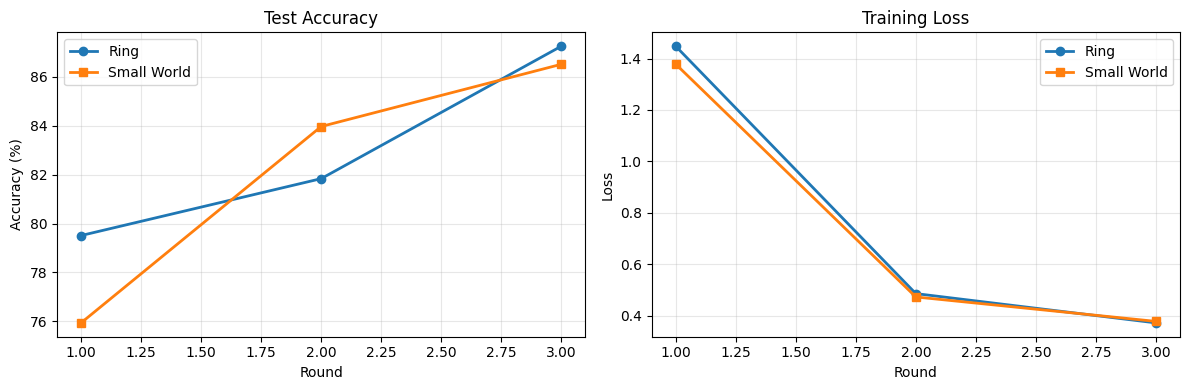

Decentralized FL Complete - Ring: 87.3%, Small World: 86.5%


In [16]:
# Results Visualization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Extract data
rounds_ring = [r['round'] for r in results_ring]
acc_ring = [r['accuracy'] for r in results_ring]
loss_ring = [r['loss'] for r in results_ring]

rounds_sw = [r['round'] for r in results_sw]
acc_sw = [r['accuracy'] for r in results_sw]
loss_sw = [r['loss'] for r in results_sw]

# Accuracy plot
ax1.plot(rounds_ring, acc_ring, 'o-', label='Ring', linewidth=2)
ax1.plot(rounds_sw, acc_sw, 's-', label='Small World', linewidth=2)
ax1.set_xlabel('Round')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Test Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(rounds_ring, loss_ring, 'o-', label='Ring', linewidth=2)
ax2.plot(rounds_sw, loss_sw, 's-', label='Small World', linewidth=2)
ax2.set_xlabel('Round')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Decentralized FL Complete - Ring: {results_ring[-1]['accuracy']:.1f}%, Small World: {results_sw[-1]['accuracy']:.1f}%")

## 3-Phase Decentralized FL Communication

### **Phase 1: Client Selection**
- `select_neighbors()`: Each client selects subset of neighbors  
- Strategies: `'random'` (with ratio), `'all'`
- Extensible for future strategies (distance-based, performance-based, etc.)

### **Phase 2: Model Transmission** 
- `transmit_to_selected()`: Selected clients send models
- `receive_model()`: Clients store incoming models
- Asynchronous communication simulation

### **Phase 3: Model Aggregation**
- `aggregate_received_models()`: Combine own + received models
- Formula: `(1-ρ) × own_model + ρ × avg_received_models`
- Clear received models after aggregation